# 06. 성능향상
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob

## 실습: 꽃 분류 모델 만들기

---
### **데이터셋**
---



<p align='center'>
<img src=https://www.tensorflow.org/tutorials/load_data/images_files/output_AAY3LJN28Kuy_0.png width=400>
</p>


#### **이미지 데이터 경로 설정**

* 데이터 불러오기
  * https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

In [ ]:
from tensorflow.keras import utils
data_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = utils.get_file('flower_photos',origin = data_url,untar=True)

print(data_dir)

228827136/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


* 데이터 경로 확인

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

```

In [ ]:
! ls /root/.keras/datasets/flower_photos


daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


* 데이터 개수 확인

In [ ]:
for class_name in ['daisy',  'dandelion', 'roses ', 'sunflowers',  'tulips']:
  #각 폴더의 파일들을 확인
  f_list=glob.glob('%s/%s/*jpg'%(data_dir,class_name))
  print(class_name)
  print(len(f_list))

daisy
633
dandelion
898
roses 
0
sunflowers
699
tulips
799


* 이미지 확인

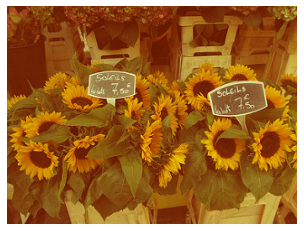

In [ ]:
class_name = 'sunflowers'
f_list=glob.glob('%s/%s/*jpg'%(data_dir,class_name))
img= plt.imread(f_list[5])
plt.axis('off')
plt.imshow(img)


#### **텐서플로우 데이터셋 준비**

In [ ]:
from tensorflow.keras import preprocessing

IMG_SIZE =160
BATCH_SIZE= 16
N_CLASS = 5

* 데이터 전처리
  *  `tf.keras.preprocessing`

In [ ]:
train_ds  = preprocessing.image_dataset_from_directory(data_dir,#데이터가 위치한 경로
                                                       subset="training",
                                                       validation_split = 0.2,
                                                       image_size = (IMG_SIZE,IMG_SIZE),
                                                       batch_size = BATCH_SIZE,
                                                       seed=123)
valid_ds  = preprocessing.image_dataset_from_directory(data_dir,#데이터가 위치한 경로
                                                       subset="validation",
                                                       validation_split = 0.2,
                                                       image_size = (IMG_SIZE,IMG_SIZE),
                                                       batch_size = BATCH_SIZE,
                                                       seed=123)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
valid_ds

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

* `ds.class_names`: 라벨의 종류를 확인합니다.

In [ ]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
valid_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

* `ds.take()`: 배치 단위의 데이터셋을 로드합니다.

In [ ]:
for imgs, labels in train_ds.take(1):
  print(imgs.shape)
  print(labels.shape)

(16, 160, 160, 3)
(16,)


* 데이터셋 시각화

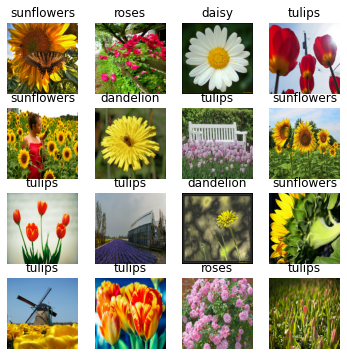

In [ ]:
plt.figure(figsize = (6,6))
for imgs, labels in train_ds.take(1):
  for i, (img,label) in enumerate(zip(imgs,labels)):
    plt.subplot(4,4,i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(train_ds.class_names[label])
    plt.axis('off')

---
### **CNN 모델 적용**
---

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers

#### **모델**

* 모델 구성

In [ ]:
x = layers.Input(shape= (IMG_SIZE,IMG_SIZE, 3))
z = layers.experimental.preprocessing.Rescaling(1./255)(x)
z = layers.Conv2D(32, 3, activation='relu')(z)
z = layers.MaxPooling2D()(z)
z = layers.Conv2D(32, 3, activation='relu')(z)
z = layers.MaxPooling2D()(z)
z = layers.Conv2D(32, 3, activation='relu')(z)
z = layers.MaxPooling2D()(z)
z = layers.Conv2D(32, 3, activation='relu')(z)
z = layers.MaxPooling2D()(z)
z = layers.Flatten()(z)
z = layers.Dense(1024, activation= 'relu')(z)
y = layers.Dense(N_CLASS,activation='softmax')(z)
model = models.Model(x,y)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 79, 79, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                       

* 컴파일

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer = optimizers.RMSprop(),
              metrics = ['accuracy'])

* 학습

In [ ]:
history = model.fit(train_ds, #데이터셋 안에 있는 x,y가 자동으로 같이입력
                    validation_data = valid_ds, #valid 데이터 입력
                    epochs= 15
                    )

Epoch 1/15
184/184 [==============================] - 21s 60ms/step - loss: 1.3608 - accuracy: 0.4080 - val_loss: 1.1524 - val_accuracy: 0.5177
Epoch 2/15
184/184 [==============================] - 8s 44ms/step - loss: 0.9913 - accuracy: 0.6073 - val_loss: 1.0071 - val_accuracy: 0.6131
Epoch 3/15
184/184 [==============================] - 8s 44ms/step - loss: 0.8469 - accuracy: 0.6761 - val_loss: 1.0202 - val_accuracy: 0.6322
Epoch 4/15
184/184 [==============================] - 8s 43ms/step - loss: 0.7316 - accuracy: 0.7221 - val_loss: 0.8032 - val_accuracy: 0.6975
Epoch 5/15
184/184 [==============================] - 8s 43ms/step - loss: 0.6073 - accuracy: 0.7738 - val_loss: 1.4778 - val_accuracy: 0.5477
Epoch 6/15
184/184 [==============================] - 9s 50ms/step - loss: 0.4868 - accuracy: 0.8239 - val_loss: 1.1340 - val_accuracy: 0.6567
Epoch 7/15
184/184 [==============================] - 9s 51ms/step - loss: 0.3891 - accuracy: 0.8587 - val_loss: 1.1527 - val_accuracy: 0.696


#### **성능평가**


* 평가

In [ ]:
model.evaluate(valid_ds)

46/46 [==============================] - 1s 28ms/step - loss: 2.7731 - accuracy: 0.6485


[2.7731101512908936, 0.6485013365745544]

* learning curve

In [ ]:
def plot_lcurve(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  plt.style.use('ggplot')
  plt.figure(figsize = (15,5))

  plt.subplot(1,2,1)
  plt.title('Accuracy')
  plt.plot(acc, marker='.', label = 'train')
  plt.plot(val_acc, marker='.' , label = 'valid')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title("loss")
  plt.plot(loss, marker='.' , label = 'train')
  plt.plot(val_loss, marker='.' ,label = 'valid')
  plt.legend()
  plt.show()

---
### **성능 향상 기법 적용**
---

#### **(1)데이터 증강기법 (Data Augmentation)**


데이터 증식은 진짜 같은 훈련 샘플을 인공적으로 생성하여 훈련 세트의 크기를 늘립니다. 데이터 증식은 과대 적합을 줄이므로 규제 기법으로 사용할 수 있습니다. 

데이터셋의 모든 이미지의 크기를 조금 변경하거나 이동, 회전한다면 모델은 이미지에 있는 물체의 위치, 방향, 크기 변화에 덜 민감해질 겁니다. 만약 이미지의 명암을 조절한다면 조명 조건에 민감하지 않은 모델을 만들 수 있습니다. 

<p align='center'>
<img src=https://ichi.pro/assets/images/max/724/1*aE2kvL2QR6VrdcQktSdx2w.png  width=500>
</p>


* `tensorflow keras`의 `layers.experimental.preprocessing` 을 이용한 데이터 증강

In [ ]:
aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

* 증강 시각화

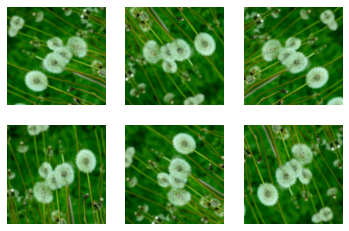

In [ ]:
for imgs, labels, in train_ds.take(1):
  img = imgs[0]
  for i in range(6):
    plt.subplot(2,3,i+1)
    aug_img = aug(img)
    plt.imshow(aug_img/255)
    plt.axis('off')
plt.show()

#### **(2) 전이학습 (Transfer learning)**

일반적으로 아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것은 좋은 생각이 아닙니다. 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음 그 신경망의 하위층을 재사용하는 것이 좋습니다. 


<p align='center'>
<img src=https://www.researchgate.net/publication/343668573/figure/fig3/AS:924645373014016@1597464044455/Transfer-learning-by-using-fine-tuning.ppm  width=500>
</p>



* 모델 불러오기

In [ ]:
from tensorflow.keras import applications
base_model = applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                      include_top=False,
                                      weights='imagenet')
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

* 원본 모델의 가중치를 고정합니다.

In [ ]:
base_model.trainable = False

* 모델을 새로 구성합니다.

In [ ]:
x = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
z = aug(x)                                        #데이터 증강
z = applications.mobilenet_v2.preprocess_input(z) #모바일 넷에 맞는 전처리
z = base_model(z,training= False)
z = layers.GlobalAveragePooling2D()(z)    #z = layers.Flatten()대신 쓰는것
z = layers.Dropout(0.2)(z)
y = layers.Dense(N_CLASS,activation='softmax')(z)
transfer = models.Model(x,y)
transfer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (160, 160, 3)             0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

#### **(3) 학습률 스케줄링 (learning rate scheduler)**

좋은 학습률을 찾는 것은 매우 중요합니다. 학습률을 너무 크게 잡으면 훈련이 발산할 수도 있고 너무 작게 잡으면 최적점에 수렴하겠지만 수렴하기까지 시간이 매우 오래 걸립니다. 

일정한 학습률보다 더 나은 방법은 처음에 큰 학습률로 시작하고 학습 속도가 느려지면 학습률을 낮추는 것입니다. 이렇게 훈련하는 동안 학습률을 감소시키는 전략은 여러가지가 있습니다.

* 거듭제곱 기반 스케줄링 (power scheduling)
* 지수 기반 스케줄링 (exponential scheduling)
* 구간별 고정 스케줄링 (piecewise constant scheduling)
* 성능 기반 스케줄링 (performance scheduling)
* 1사이클 스케줄링 (cycle scheduling)

* `callbacks` 을 이용해 학습 중간에 모델을 저장하고 학습률 스케줄링을 지정할 수 있습니다.

In [ ]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        factor=0.2,
                                        patience=3,
                                        min_lr = 0.000001)
ckp = callbacks.ModelCheckpoint(filepath='transfer.h5',save_best_only=True)

* 컴파일

In [ ]:
transfer.compile(loss = losses.SparseCategoricalCrossentropy(),
                 optimizer =optimizers.RMSprop(learning_rate=0.0001),
                 metrics = ['accuracy'])

* 학습

In [ ]:
history_transfer  = transfer.fit(train_ds, 
                                 validation_data=valid_ds,
                                 epochs =20,
                                callbacks = [reduce_lr,ckp])

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.4029WARNING:tensorflow:Model was constructed with shape (160, 160, 3) for input KerasTensor(type_spec=TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 160, 160, 3).


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


184/184 [==============================] - 21s 109ms/step - loss: 1.4858 - accuracy: 0.4029 - val_loss: 1.0804 - val_accuracy: 0.6117 - lr: 1.0000e-04
Epoch 2/20
184/184 [==============================] - 10s 52ms/step - loss: 1.0123 - accuracy: 0.6148 - val_loss: 0.8151 - val_accuracy: 0.7044 - lr: 1.0000e-04
Epoch 3/20
184/184 [==============================] - 10s 53ms/step - loss: 0.8135 - accuracy: 0.6986 - val_loss: 0.6769 - val_accuracy: 0.7548 - lr: 1.0000e-04
Epoch 4/20
184/184 [==============================] - 11s 61ms/step - loss: 0.6929 - accuracy: 0.7531 - val_loss: 0.5971 - val_accuracy: 0.7888 - lr: 1.0000e-04
Epoch 5/20
184/184 [==============================] - 17s 89ms/step - loss: 0.6195 - accuracy: 0.7810 - val_loss: 0.5473 - val_accuracy: 0.8120 - lr: 1.0000e-04
Epoch 6/20
184/184 [==============================] - 12s 62ms/step - loss: 0.5731 - accuracy: 0.8021 - val_loss: 0.5105 - val_accuracy: 0.8215 - lr: 1.0000e-04
Epoch 7/20
184/184 [========================

**성능평가 : 전이학습**

* 평가

In [ ]:
transfer.evaluate(valid_ds)

46/46 [==============================] - 3s 48ms/step - loss: 0.3750 - accuracy: 0.8678


[0.3749670386314392, 0.8678473830223083]

* learning curve

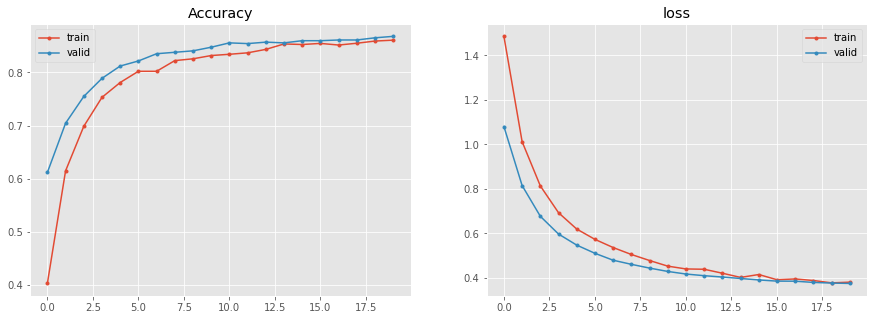

In [ ]:
plot_lcurve(history_transfer)

#### **(4) 미세 조정**

 MobileNet 모델이 아닌 소수의 최상위(마지막 레이어) 층을 미세 조정해야 합니다. 대부분의 컨볼루션 네트워크에서는 상위 층으로 갈 수록 이미지에 대한 전문적인 특징을 가지게 됩니다. 반면 처음 층들은 이미지의 간단하고 일반적인 특징을 가지게 됩니다. 미세 조정의 목표는 상위층의 전문화된 특징이 우리의 새 데이터에 잘 동작하도록 조정하는 것입니다.




* 최상위 층 고정 해제하기

`base_model`을 고정 해제하고 맨 아래 층(처음 부분 층)을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [ ]:
base_model.trainable = True

* 최상위층을 제외하고 고정하기

In [ ]:
print(len(base_model.layers))
for layer in base_model.layers[:100]:
  layer.trainable = False
  

154


In [ ]:
transfer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (160, 160, 3)             0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

* 모델 컴파일

훨씬 더 큰 모델을 훈련하고 있고 사전 훈련된 가중치를 다시 조정하려면 이 단계에서 낮은 학습률을 사용하는 것이 중요합니다. 그렇지 않으면 모델이 매우 빠르게 과대적합될 수 있습니다.

In [ ]:
transfer.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer = optimizers.RMSprop(learning_rate=0.0001/10),
              metrics = ['accuracy'])

* 학습

In [ ]:
history_fine = transfer.fit(train_ds,
                            epochs = 20,
                            validation_data=valid_ds,
                            callbacks=[ckp,reduce_lr])

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8597WARNING:tensorflow:Model was constructed with shape (160, 160, 3) for input KerasTensor(type_spec=TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 160, 160, 3).


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


184/184 [==============================] - 31s 106ms/step - loss: 0.3734 - accuracy: 0.8597 - val_loss: 0.3468 - val_accuracy: 0.8678 - lr: 1.0000e-05
Epoch 2/20
184/184 [==============================] - 18s 94ms/step - loss: 0.3182 - accuracy: 0.8767 - val_loss: 0.3322 - val_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 3/20
184/184 [==============================] - 18s 94ms/step - loss: 0.2770 - accuracy: 0.8988 - val_loss: 0.3024 - val_accuracy: 0.8896 - lr: 1.0000e-05
Epoch 4/20
184/184 [==============================] - 19s 99ms/step - loss: 0.2657 - accuracy: 0.9046 - val_loss: 0.2886 - val_accuracy: 0.9033 - lr: 1.0000e-05
Epoch 5/20
184/184 [==============================] - 18s 93ms/step - loss: 0.2346 - accuracy: 0.9097 - val_loss: 0.2924 - val_accuracy: 0.8992 - lr: 1.0000e-05
Epoch 6/20
184/184 [==============================] - 18s 98ms/step - loss: 0.2213 - accuracy: 0.9155 - val_loss: 0.2813 - val_accuracy: 0.8951 - lr: 1.0000e-05
Epoch 7/20
184/184 [========================

**성능평가 : 미세조정**

* 평가

In [ ]:
transfer.evaluate(valid_ds)

46/46 [==============================] - 3s 51ms/step - loss: 0.2422 - accuracy: 0.9169


[0.24217796325683594, 0.916893720626831]

* learning curve

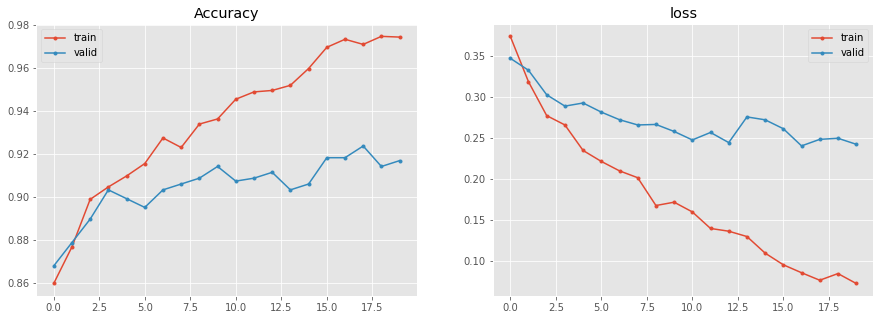

In [ ]:
plot_lcurve(history_fine)

---
### **모델 사용**
---

#### **모델 저장과 로드**

* `.save('model_name')` :
모델을 저장합니다.

In [ ]:
transfer.save('flower_classifier.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


* `models.load_model('model_name')`: 모델을 불러옵니다.

In [ ]:
flower_model = models.load_model('flower_classifier.h5')

* 평가

#### **모델 사용** 

* `valid_ds` 로 테스트

(160, 160, 3) (16,)
(16, 5)
[2 0 3 4 0 2 4 0 2 4 0 4 3 3 2 0]
[2 0 3 4 0 2 4 0 2 0 0 4 3 3 2 0]


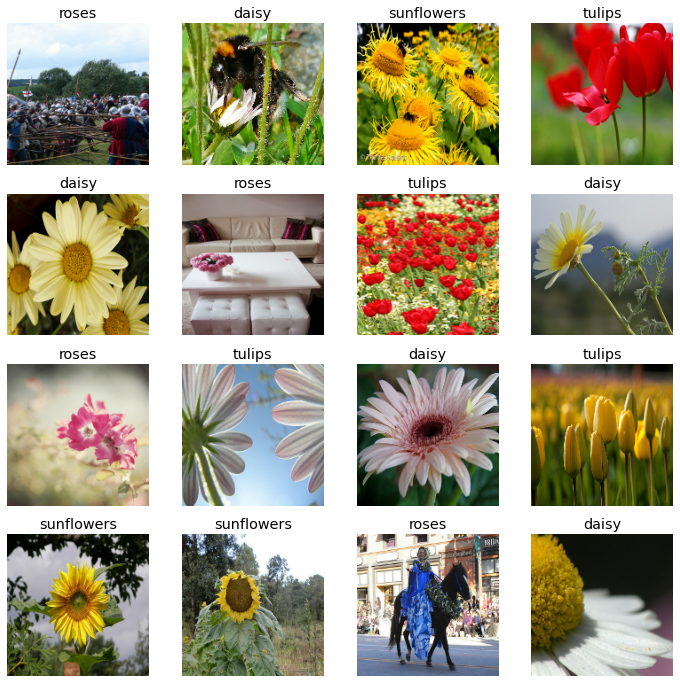

In [ ]:
imgs, labels = valid_ds.as_numpy_iterator().next()
print(img.shape,labels.shape)
preds = transfer.predict_on_batch(imgs)
print(preds.shape)
preds = np.argmax(preds,axis=1)
print(preds)
print(labels)
plt.figure(figsize=(12,12))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(imgs[i].astype("uint8"))
  plt.title(valid_ds.class_names[preds[i]])
  plt.axis('off')
plt.show()

* 새로운 이미지로 테스트

<PIL.Image.Image image mode=RGB size=160x160 at 0x7F72A3D84490>
[3]


(-0.5, 159.5, 159.5, -0.5)

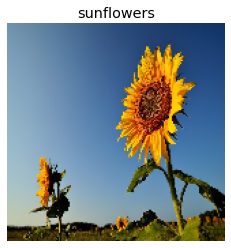

In [ ]:
img_path = 'sunflower.jpg'
#img = plt.imread(img_path)
img = preprocessing.image.load_img(img_path,
                                   target_size=(IMG_SIZE,IMG_SIZE))
print(img)
img_arr = preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)   #(1,160,160,3)
pred = transfer.predict_on_batch(img_arr)
pred= np.argmax(pred,axis=1)
print(pred)

plt.title(train_ds.class_names[pred[0]])
plt.imshow(img)
plt.axis('off')

